# <span style="color:blue"> <center>Case Geofusion - Clusterização</center></span>
## <center>3. Segmentar os bairros de São Paulo de acordo com a renda e a idade, e indicar aqueles com maior aderência ao público alvo</center>
<center>Solução proposta por Lucas Victor Silva Pereira</center>

Para ter uma ideia de como os algoritmos de clusterização irão se comportar frente aos dados dos bairros da cidade de São Paulo, eles serão usados para clusterizar os bairros da cidade do Rio de Janeiro. Como os dados referentes ao Rio de janeiro são classificados (rotulados) é possível ter uma noção de como os bairros de São Paulo serão clusterizados.

In [1]:
#Required Libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline

#importa as bibliotecas básicas
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
from sklearn.metrics.cluster import adjusted_rand_score, mutual_info_score
from sklearn.metrics import silhouette_score
#from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage


### **<center>Tratamento dos Dados</center>**

In [2]:
#Read and process the database
url = 'dataset/DadosDeliciousFood.csv'

dfFoodB = pd.read_csv(url, encoding='utf-8')
dfFoodB = dfFoodB.drop_duplicates()
if (dfFoodB.duplicated('codigo').sum() > 0):
    print("ALERT: DATA CONFLICT. Check possible solutions with data engineers.")
dfFoodB = dfFoodB.replace('-', np.nan)
dfFoodB = dfFoodB.replace('?', np.nan)

mask = ((dfFoodB['popAte9'] == 0) & (dfFoodB['popDe10a14'] == 0) & (dfFoodB['popDe15a19'] == 0) & \
        (dfFoodB['popDe20a24'] == 0) & (dfFoodB['popDe25a34'] == 0) & (dfFoodB['popDe35a49'] == 0) & \
        (dfFoodB['popDe50a59'] == 0) & (dfFoodB['popMaisDe60'] == 0)) |\
       ((dfFoodB['domiciliosA1'] == 0) & (dfFoodB['domiciliosA2'] == 0) & (dfFoodB['domiciliosB1'] == 0) & \
        (dfFoodB['domiciliosB2'] == 0) & (dfFoodB['domiciliosC1'] == 0) & (dfFoodB['domiciliosC2'] == 0) & \
        (dfFoodB['domiciliosD'] == 0) & (dfFoodB['domiciliosE'] == 0)) |\
       (dfFoodB['população'] != (dfFoodB['popAte9'] + dfFoodB['popDe10a14'] + dfFoodB['popDe15a19'] + \
                                 dfFoodB['popDe20a24'] + dfFoodB['popDe25a34'] + dfFoodB['popDe35a49'] + \
                                 dfFoodB['popDe50a59'] + dfFoodB['popMaisDe60'])) |\
       ((dfFoodB['rendaMedia'] == 0) & (dfFoodB['faturamento'] == 0))
dfFoodB = dfFoodB.loc[~mask]

dfFoodB = dfFoodB.drop(['codigo','nome','cidade','população','faturamento'], axis=1)

dfFoodBRJ = dfFoodB.loc[dfFoodB['estado'] == "RJ"]
dfFoodBRJ = dfFoodBRJ.dropna(axis='rows') #remove rows NaN/null

dfFoodBRJY = dfFoodBRJ['potencial']

dfFoodBRJ = dfFoodBRJ.drop(['estado','potencial'], axis=1)
dfFoodBRJ = dfFoodBRJ.astype('float')

dfFoodBRJ['rendaMedia'] = np.log(dfFoodBRJ['rendaMedia'])

dfFoodBRJX = dfFoodBRJ[['popDe25a34','popDe35a49','popDe50a59','popMaisDe60','domiciliosA1',\
                        'domiciliosA2','domiciliosB1','domiciliosB2','rendaMedia']]


dfFoodBSP = dfFoodB.loc[dfFoodB['estado'] == "SP"]
dfFoodBSP = dfFoodBSP.drop(['estado','potencial'], axis=1)
dfFoodBSP = dfFoodBSP.dropna(axis='rows') #remove rows NaN/null
dfFoodBSP = dfFoodBSP.astype('float')
dfFoodBSP['rendaMedia'] = np.log(dfFoodBSP['rendaMedia'])


dfFoodBSPX = dfFoodBSP[['popDe25a34','popDe35a49','popDe50a59','popMaisDe60','domiciliosA1',\
                        'domiciliosA2','domiciliosB1','domiciliosB2','rendaMedia']]

scaler = StandardScaler().fit(dfFoodBSPX)
dfFoodBSPX = scaler.transform(dfFoodBSPX)

scaler = StandardScaler().fit(dfFoodBRJX)
dfFoodBRJX = scaler.transform(dfFoodBRJX)

scaler = StandardScaler().fit(dfFoodBSP)
FoodBSP = scaler.transform(dfFoodBSP)

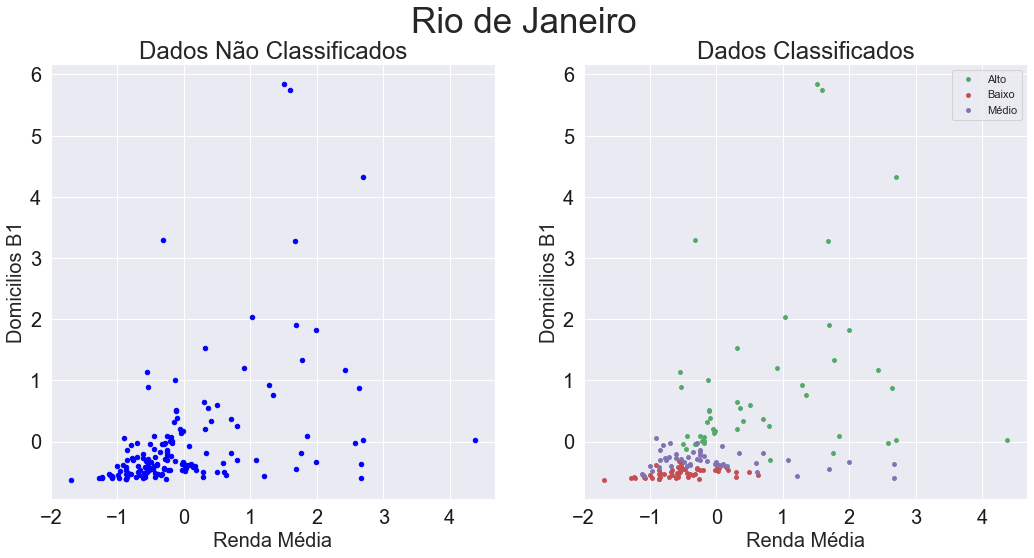

In [3]:
colors = ['g', 'r', 'm'] # define the possible colors 

sns.set(rc={'figure.figsize':(17.5,8)})
fig,axes = plt.subplots(1,2)
fig.suptitle('Rio de Janeiro', fontsize=35)
plt.subplot(1,2, 1)

plt.scatter(x=dfFoodBRJX[:,8], y=dfFoodBRJX[:,6], s=20, color = 'blue')
plt.title('Dados Não Classificados', fontsize=24)
plt.ylabel("Domicilios B1", fontsize=20)
plt.xlabel("Renda Média", fontsize=20)
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20)

cl = np.unique(dfFoodBRJY)

aux = 0
plt.subplot(1,2, 2)
for c in cl:
    nodes = np.where(dfFoodBRJY == c)
    # mostra os dados,considerando uma cor para cada classe
    plt.scatter(x=dfFoodBRJX[nodes,8], y=dfFoodBRJX[nodes,6], s=15, color = colors[aux], label = c)
    aux = aux + 1
plt.legend()
plt.ylabel("Domicilios B1", fontsize=20)
plt.xlabel("Renda Média", fontsize=20)
plt.title('Dados Classificados', fontsize=24)
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20)
plt.show(True)

## **<center>Clusterização - Rio de Janeiro</center>**

### **<center>1. Kmeans++</center>**

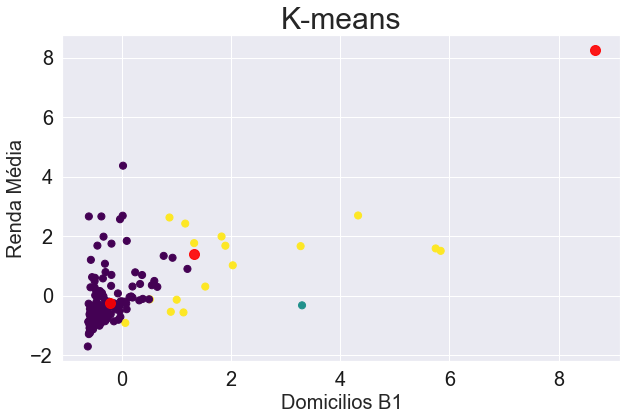

In [4]:
k = 3 # numero de clusters a serem identificados
# define o método com k clusters
kmeans = cluster.KMeans(init='k-means++', n_clusters=k, n_init=300) #kmeans = cluster.KMeans(n_clusters=k)
# realiza o ajuste considerando os dados X
kmeans.fit(dfFoodBRJX)
# faz a predição, identificando os clusters
y_km = kmeans.fit_predict(dfFoodBRJX)
# define o tamanha da figura
plt.figure(figsize=(10,6))
# mostra o primeiro gráfico
plt.scatter(dfFoodBRJX[:,6], dfFoodBRJX[:,8], c=y_km, cmap='viridis', s=50)
plt.title('K-means', size=30)
centers = kmeans.cluster_centers_
# mostra os centróides obtidos
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.9);
plt.xlabel("Domicilios B1", fontsize=20)
plt.ylabel("Renda Média", fontsize=20)
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20)
plt.show(True)

In [5]:
print('K-means:')
print('Adjusted rand score:', adjusted_rand_score(y_km, dfFoodBRJY))
print('Mutual information score:', mutual_info_score(y_km, dfFoodBRJY))
print('Silhouette score:', silhouette_score(dfFoodBRJX, y_km, metric='euclidean'))
print('\n')

K-means:
Adjusted rand score: 0.056793378221518566
Mutual information score: 0.11764286802670795
Silhouette score: 0.669619384093935




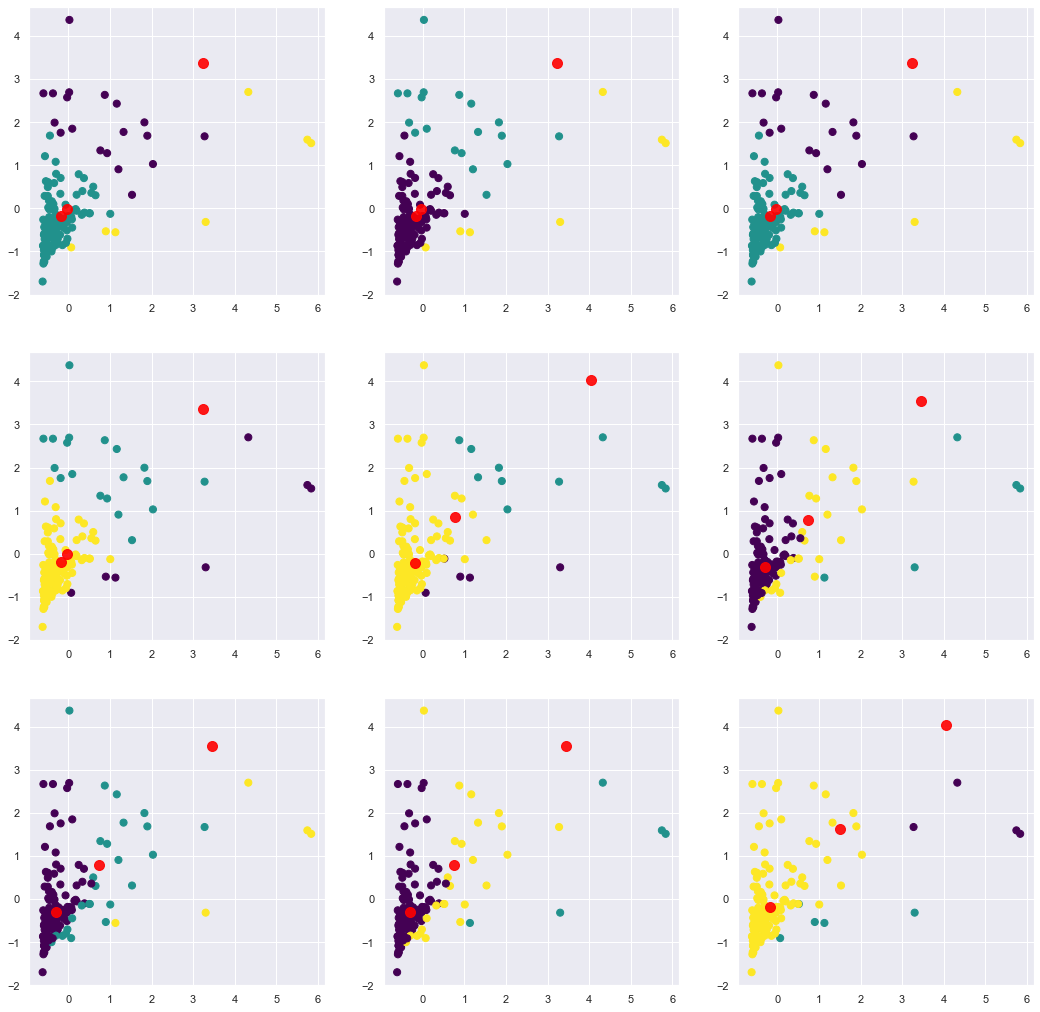

In [6]:
plt.figure(figsize=(18,18))
# Mostra 9 execuções diferentes do algoritmo no mesmo conjunto de dados
for s in np.arange(1,10):
    kmeans = cluster.KMeans(n_clusters=k, init= 'random', n_init=1)
    kmeans.fit(dfFoodBRJX)
    y_km = kmeans.fit_predict(dfFoodBRJX)
    plt.subplot(3, 3, s)
    plt.scatter(dfFoodBRJX[:,6], dfFoodBRJX[:,8], c=y_km, cmap='viridis', s=50) #plt.scatter(FoodBRJ[:,6], FoodBRJ[:,8], c=y_km, cmap='viridis', s=50)
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.9);
plt.show(True)

### **<center>2. Ward<br>3. Complete Linkage<br>4. Average Linkage<br>5. Single Linkage</center>**

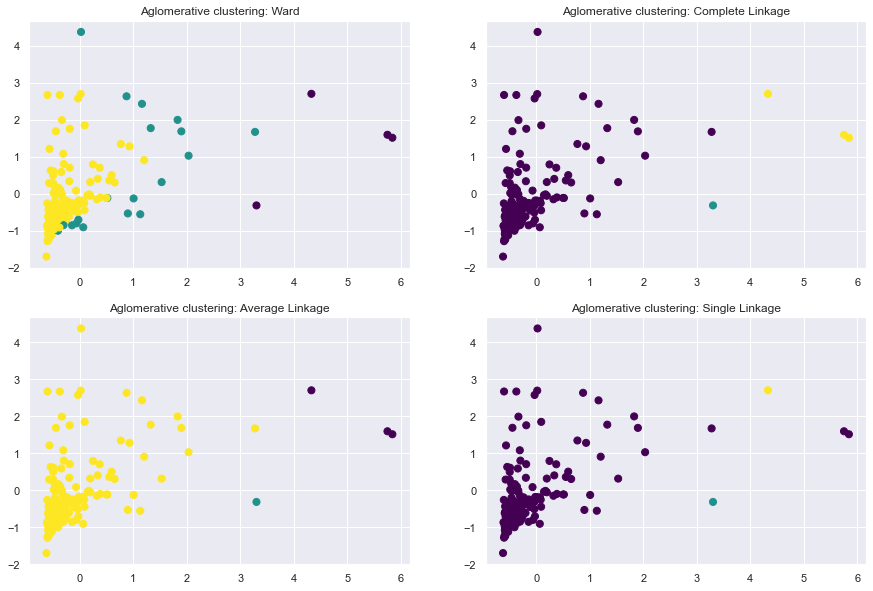

In [7]:
plt.figure(figsize=(15,10))
clustering = cluster.AgglomerativeClustering(n_clusters=k, linkage='ward')
y_hr = clustering.fit_predict(dfFoodBRJX)
plt.subplot(2,2,1)
plt.scatter(dfFoodBRJX[:,6], dfFoodBRJX[:,8], c=y_hr, cmap='viridis', s=50) #plt.scatter(dfFoodBSP['domiciliosB1'], dfFoodBSP['popMaisDe60'], c=y_hr, cmap='viridis', s=50)
plt.title('Aglomerative clustering: Ward')

clustering = cluster.AgglomerativeClustering(n_clusters=k, linkage='complete')
y_hr = clustering.fit_predict(dfFoodBRJX)
plt.subplot(2,2,2)
plt.scatter(dfFoodBRJX[:,6], dfFoodBRJX[:,8], c=y_hr, cmap='viridis', s=50) #plt.scatter(dfFoodBSP['domiciliosB1'], dfFoodBSP['popMaisDe60'], c=y_hr, cmap='viridis', s=50)
plt.title('Aglomerative clustering: Complete Linkage')

clustering = cluster.AgglomerativeClustering(n_clusters=k, linkage='average')
y_hr = clustering.fit_predict(dfFoodBRJX)
plt.subplot(2,2,3)
plt.scatter(dfFoodBRJX[:,6], dfFoodBRJX[:,8], c=y_hr, cmap='viridis', s=50) #plt.scatter(dfFoodBSP['domiciliosB1'], dfFoodBSP['popMaisDe60'], c=y_hr, cmap='viridis', s=50)
plt.title('Aglomerative clustering: Average Linkage')

clustering = cluster.AgglomerativeClustering(n_clusters=k, linkage='single')
y_hr = clustering.fit_predict(dfFoodBRJX)
plt.subplot(2,2,4)
plt.scatter(dfFoodBRJX[:,6], dfFoodBRJX[:,8], c=y_hr, cmap='viridis', s=50) #plt.scatter(dfFoodBSP['domiciliosB1'], dfFoodBSP['popMaisDe60'], c=y_hr, cmap='viridis', s=50)
plt.title('Aglomerative clustering: Single Linkage')

plt.show(True)

### **<center>6. Dendograma</center>**

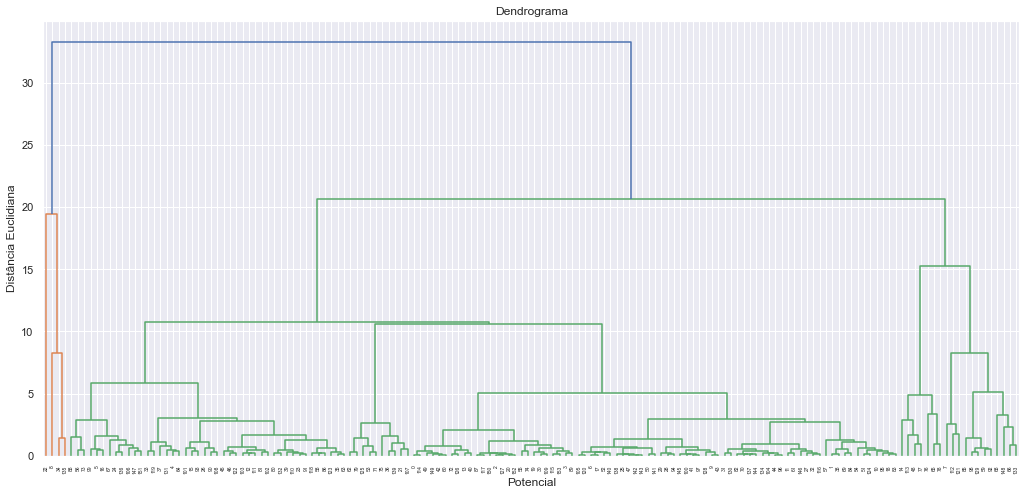

In [8]:
dendrogram(linkage(dfFoodBRJX, method = 'ward'))
plt.title('Dendrograma')
plt.xlabel('Potencial')
plt.ylabel('Distância Euclidiana')

hc = cluster.AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
predict = hc.fit_predict(dfFoodBRJX)

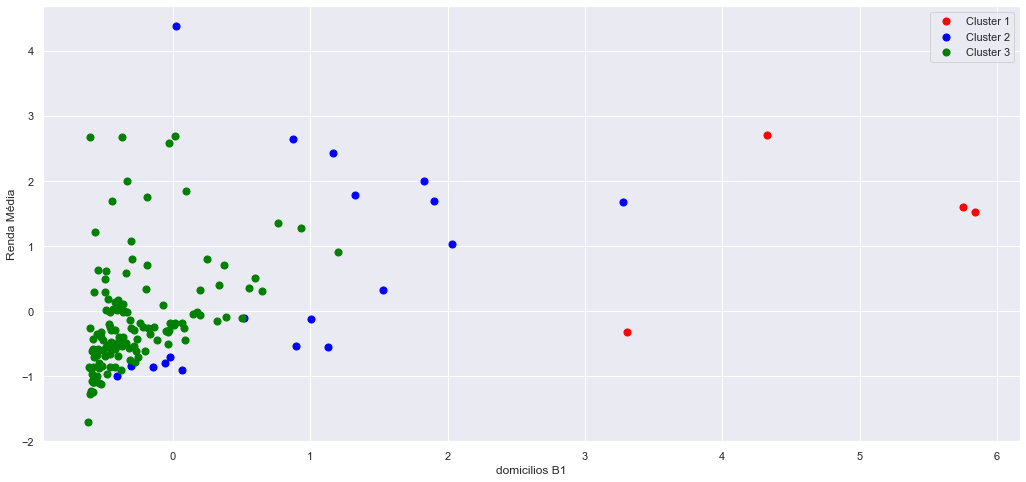

In [9]:
plt.scatter(dfFoodBRJX[predict == 0, 6], dfFoodBRJX[predict == 0, 8], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(dfFoodBRJX[predict == 1, 6], dfFoodBRJX[predict == 1, 8], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(dfFoodBRJX[predict == 2, 6], dfFoodBRJX[predict == 2, 8], s = 50, c = 'green', label = 'Cluster 3')
plt.xlabel('domicilios B1')
plt.ylabel('Renda Média')
plt.legend()
plt.show(True)

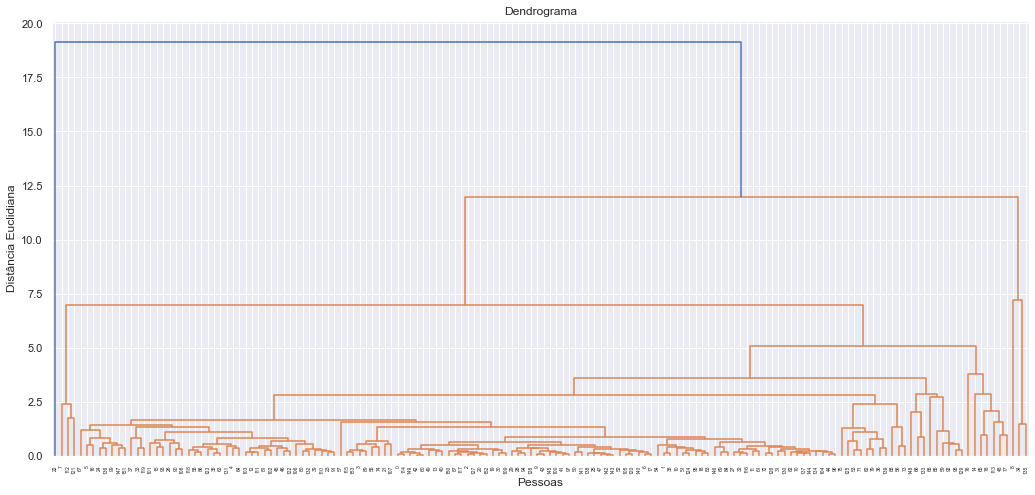

In [10]:
dendrogram(linkage(dfFoodBRJX, method = 'average'))
plt.title('Dendrograma')
plt.xlabel('Pessoas')
plt.ylabel('Distância Euclidiana')

hc = cluster.AgglomerativeClustering(n_clusters = 3, affinity = 'cosine', linkage = 'average')
predict = hc.fit_predict(dfFoodBRJX)

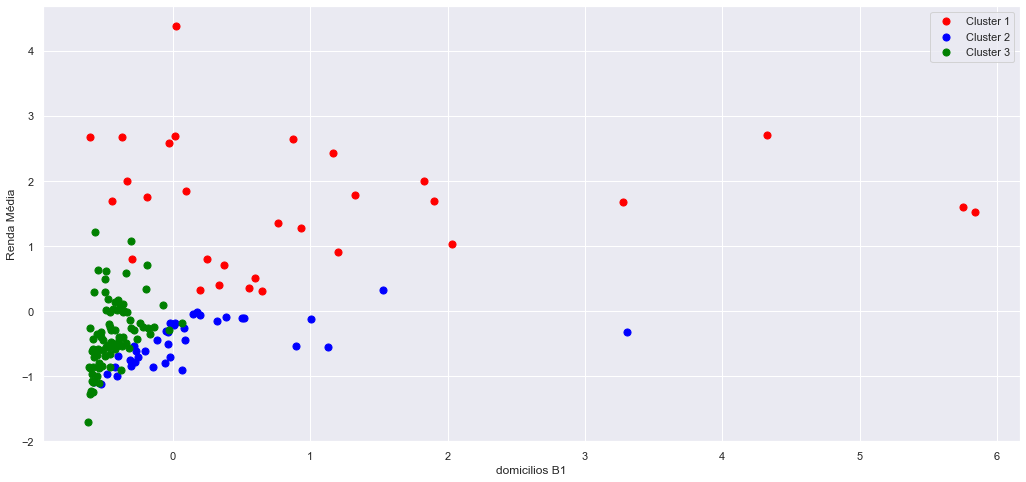

In [11]:
plt.scatter(dfFoodBRJX[predict == 0, 6], dfFoodBRJX[predict == 0, 8], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(dfFoodBRJX[predict == 1, 6], dfFoodBRJX[predict == 1, 8], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(dfFoodBRJX[predict == 2, 6], dfFoodBRJX[predict == 2, 8], s = 50, c = 'green', label = 'Cluster 3')
plt.xlabel('domicilios B1')
plt.ylabel('Renda Média')
plt.legend()
plt.show(True)

## **<center>Clusterização - São Paulo</center>**

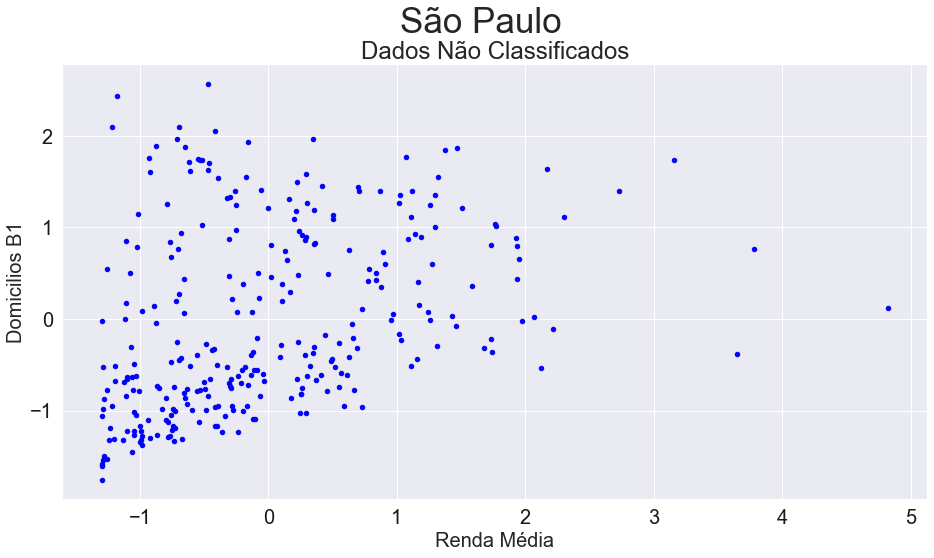

In [12]:
sns.set(rc={'figure.figsize':(15.5,8)})
fig,axes = plt.subplots(1,1)
fig.suptitle('São Paulo', fontsize=35)

plt.scatter(x=dfFoodBSPX[:,6], y=dfFoodBSPX[:,8], s=20, color = 'blue')
plt.title('Dados Não Classificados', fontsize=24)
plt.ylabel("Domicilios B1", fontsize=20)
plt.xlabel("Renda Média", fontsize=20)
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20)
plt.show(True)

### **<center>1. Kmeans++</center>**

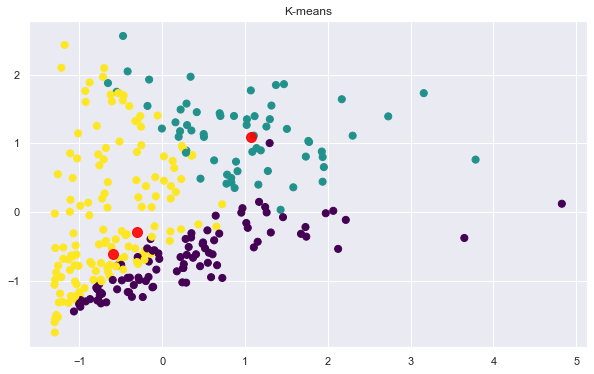

In [13]:
k = 3 # numero de clusters a serem identificados
# define o método com k clusters
kmeans = cluster.KMeans(init='k-means++', n_clusters=k, n_init=300)
# realiza o ajuste considerando os dados X
kmeans.fit(dfFoodBSPX)
# faz a predição, identificando os clusters
y_km = kmeans.fit_predict(dfFoodBSPX)
# define o tamanha da figura
plt.figure(figsize=(10,6))
# mostra o primeiro gráfico
plt.scatter(dfFoodBSPX[:,6], dfFoodBSPX[:,8], c=y_km, cmap='viridis', s=50)
plt.title('K-means')
centers = kmeans.cluster_centers_
# mostra os centróides obtidos
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.9); 

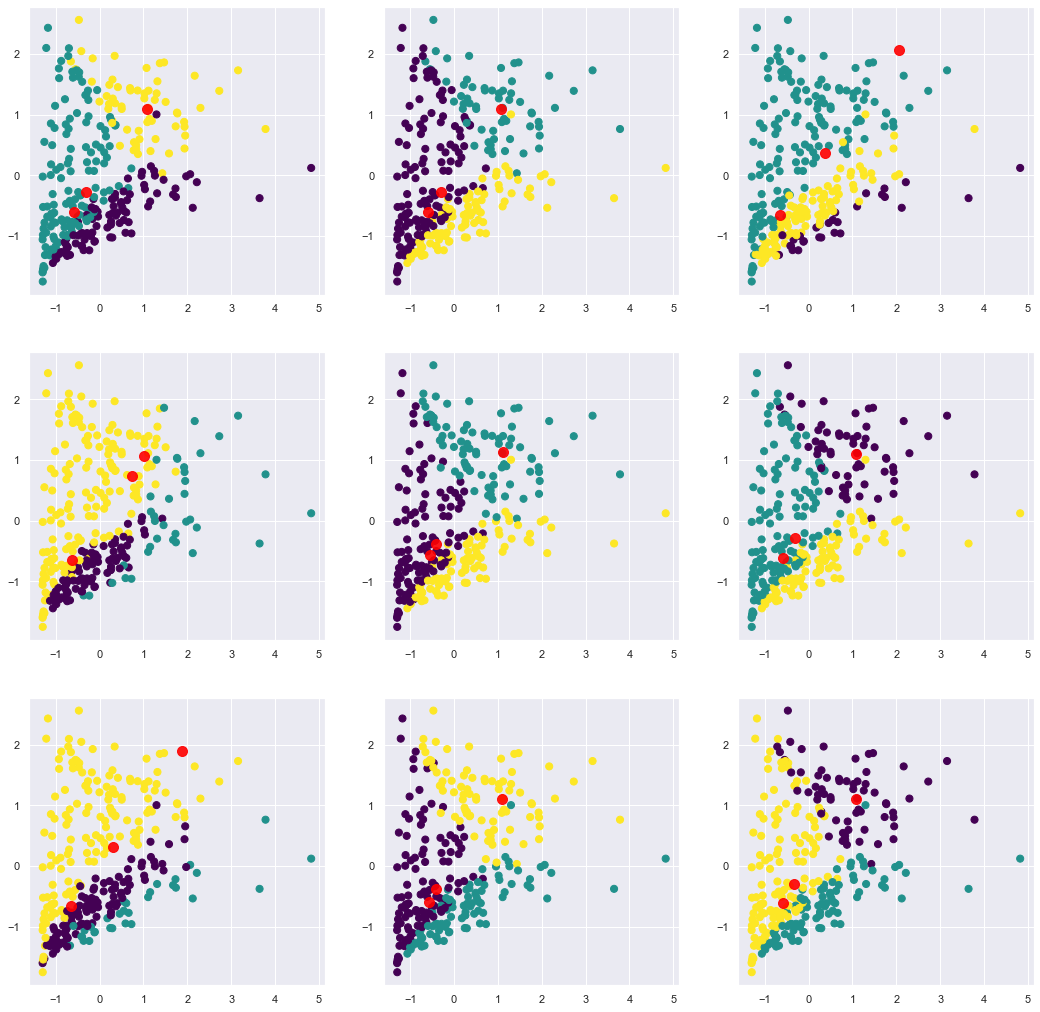

In [14]:
plt.figure(figsize=(18,18))
# Mostra 9 execuções diferentes do algoritmo no mesmo conjunto de dados
for s in np.arange(1,10):
    kmeans = cluster.KMeans(n_clusters=k, init= 'random', n_init=1)
    kmeans.fit(dfFoodBSPX)
    y_km = kmeans.fit_predict(dfFoodBSPX)
    plt.subplot(3, 3, s)
    plt.scatter(dfFoodBSPX[:,6], dfFoodBSPX[:,8], c=y_km, cmap='viridis', s=50) #plt.scatter(FoodBRJ[:,6], FoodBRJ[:,8], c=y_km, cmap='viridis', s=50)
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.9);
plt.show(True)

### **<center>2. Ward<br>3. Complete Linkage<br>4. Average Linkage<br>5. Single Linkage</center>**

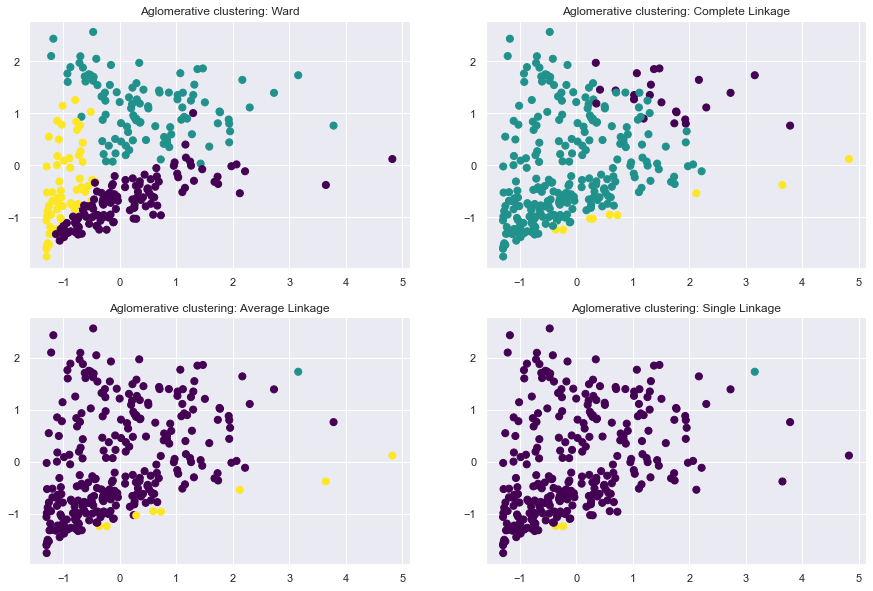

In [15]:
plt.figure(figsize=(15,10))
clustering = cluster.AgglomerativeClustering(n_clusters=k, linkage='ward')
y_hr = clustering.fit_predict(dfFoodBSPX)
plt.subplot(2,2,1)
#plt.scatter(dfFoodBSP['domiciliosB1'], dfFoodBSP['popMaisDe60'], c=y_hr, cmap='viridis', s=50)
plt.scatter(dfFoodBSPX[:,6], dfFoodBSPX[:,8], c=y_hr, cmap='viridis', s=50) 
plt.title('Aglomerative clustering: Ward')

clustering = cluster.AgglomerativeClustering(n_clusters=k, linkage='complete')
y_hr = clustering.fit_predict(dfFoodBSPX)
plt.subplot(2,2,2)
plt.scatter(dfFoodBSPX[:,6], dfFoodBSPX[:,8], c=y_hr, cmap='viridis', s=50)
plt.title('Aglomerative clustering: Complete Linkage')

clustering = cluster.AgglomerativeClustering(n_clusters=k, linkage='average')
y_hr = clustering.fit_predict(dfFoodBSPX)
plt.subplot(2,2,3)
plt.scatter(dfFoodBSPX[:,6], dfFoodBSPX[:,8], c=y_hr, cmap='viridis', s=50)
plt.title('Aglomerative clustering: Average Linkage')

clustering = cluster.AgglomerativeClustering(n_clusters=k, linkage='single')
y_hr = clustering.fit_predict(dfFoodBSPX)
plt.subplot(2,2,4)
plt.scatter(dfFoodBSPX[:,6], dfFoodBSPX[:,8], c=y_hr, cmap='viridis', s=50)
plt.title('Aglomerative clustering: Single Linkage')

plt.show(True)

### **<center>6. Dendograma</center>**

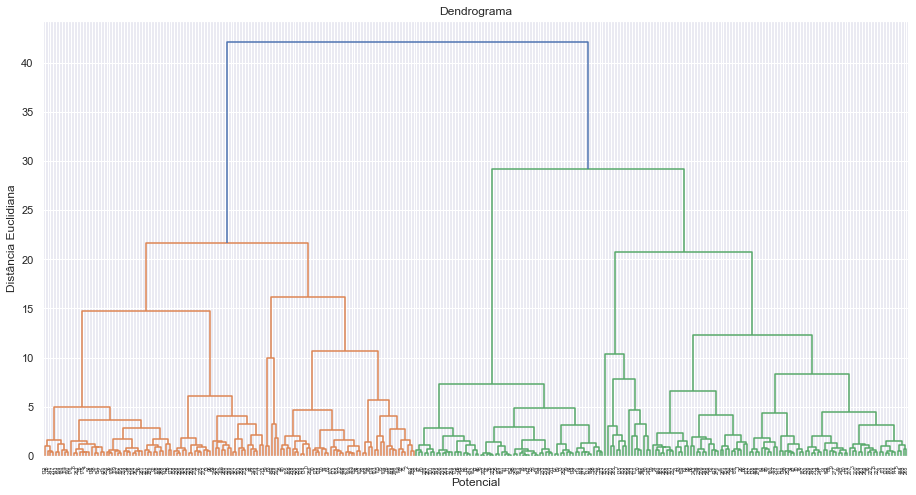

In [16]:
dendrogram(linkage(dfFoodBSPX, method = 'ward'))
plt.title('Dendrograma')
plt.xlabel('Potencial')
plt.ylabel('Distância Euclidiana')

hc = cluster.AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
predict = hc.fit_predict(dfFoodBSPX)

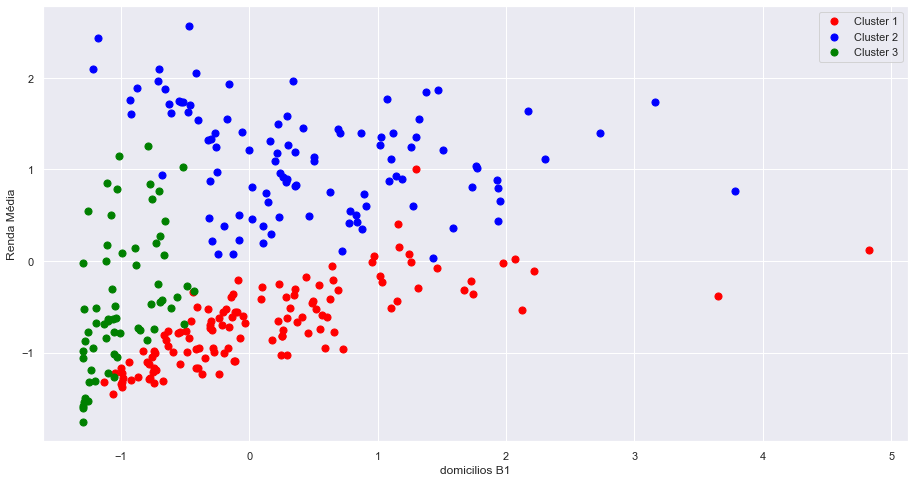

In [17]:
plt.scatter(dfFoodBSPX[predict == 0, 6], dfFoodBSPX[predict == 0, 8], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(dfFoodBSPX[predict == 1, 6], dfFoodBSPX[predict == 1, 8], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(dfFoodBSPX[predict == 2, 6], dfFoodBSPX[predict == 2, 8], s = 50, c = 'green', label = 'Cluster 3')
plt.xlabel('domicilios B1')
plt.ylabel('Renda Média')
plt.legend()
plt.show(True)

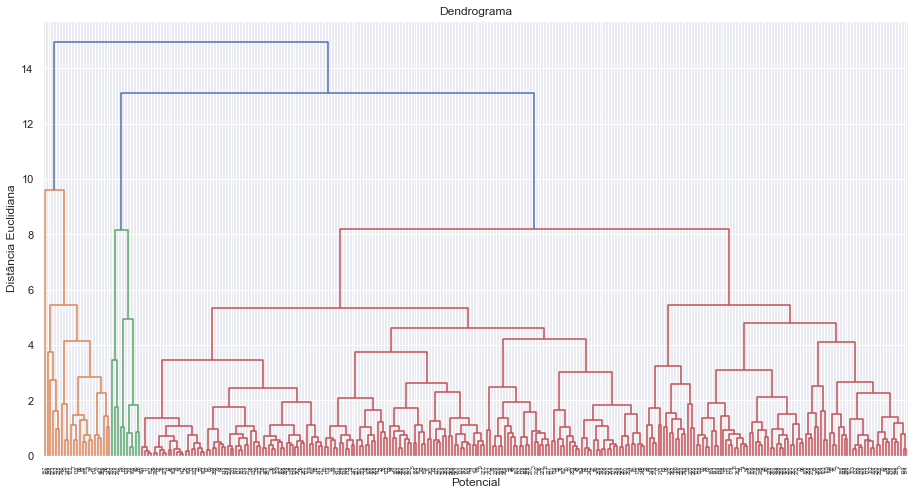

In [18]:
dendrogram(linkage(dfFoodBSPX, method = 'complete'))
plt.title('Dendrograma')
plt.xlabel('Potencial')
plt.ylabel('Distância Euclidiana')

hc = cluster.AgglomerativeClustering(n_clusters = 3, affinity = 'cosine', linkage = 'complete')
previsoes = hc.fit_predict(dfFoodBSPX)

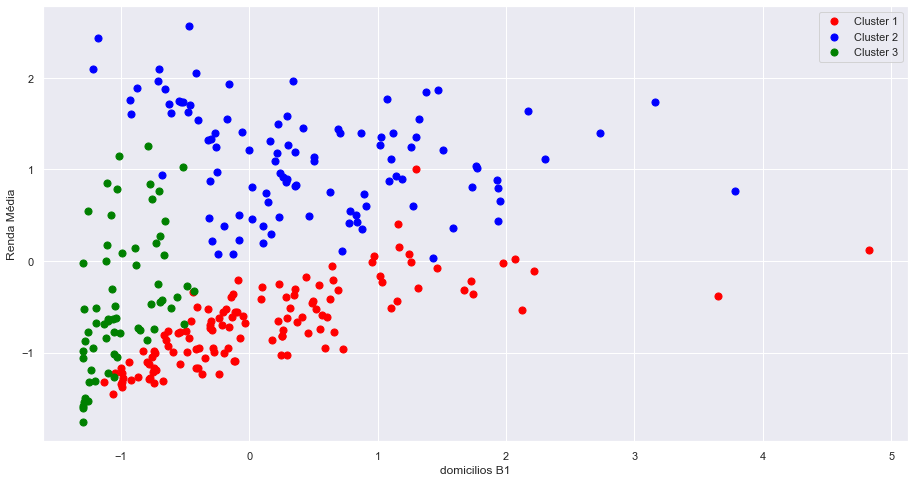

In [19]:
plt.scatter(dfFoodBSPX[predict == 0, 6], dfFoodBSPX[predict == 0, 8], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(dfFoodBSPX[predict == 1, 6], dfFoodBSPX[predict == 1, 8], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(dfFoodBSPX[predict == 2, 6], dfFoodBSPX[predict == 2, 8], s = 50, c = 'green', label = 'Cluster 3')
plt.xlabel('domicilios B1')
plt.ylabel('Renda Média')
plt.legend()
plt.show(True)